In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl
import pymaster as nmt

In [2]:
cosmo = pyccl.core.Cosmology(Omega_c=0.206, Omega_b=0.044, h=0.7, n_s=0.95, sigma8=0.8, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, m_nu=0.0, m_nu_type=None, w0=-1.0, wa=0.0, T_CMB=None)

In [3]:
z_bin_edges = np.linspace(0.8,0.9,11)
z_bin_edges_izq = z_bin_edges[:-1]
z_bin_edges_der = z_bin_edges[1:]
z_bin_centers = (z_bin_edges_izq + z_bin_edges_der)/2

mascara = hp.read_map("/afs/ciemat.es/user/d/davfer/public/mascara_map.fits", verbose=False)
pix_ocupados = np.where(mascara == 1)[0]

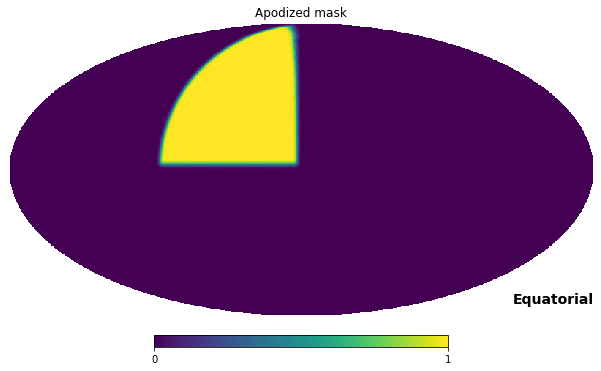

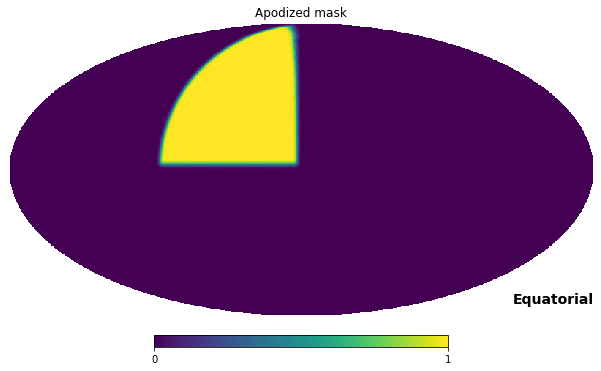

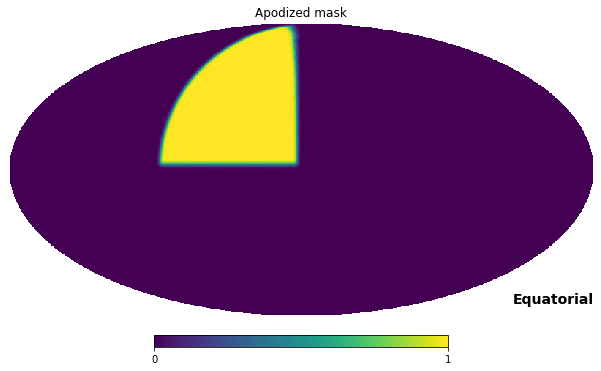

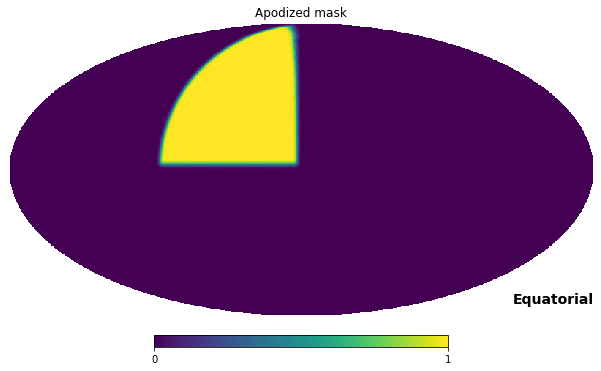

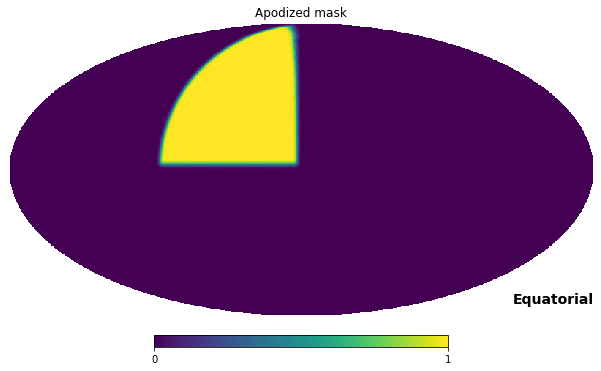

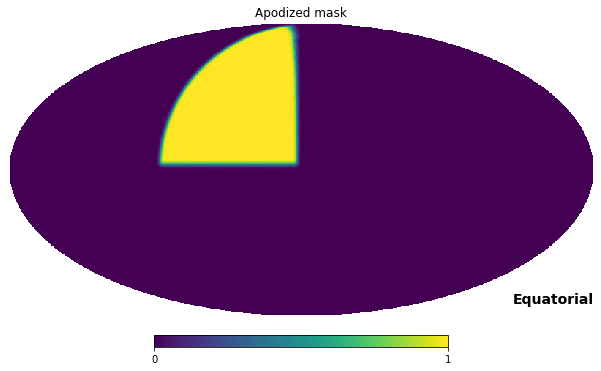

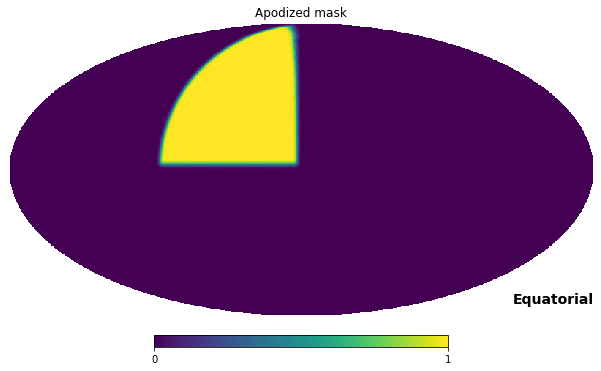

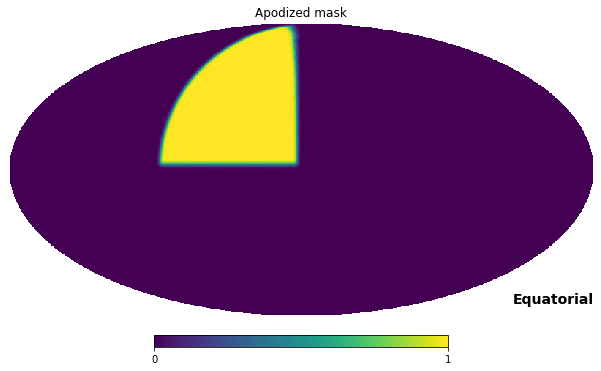

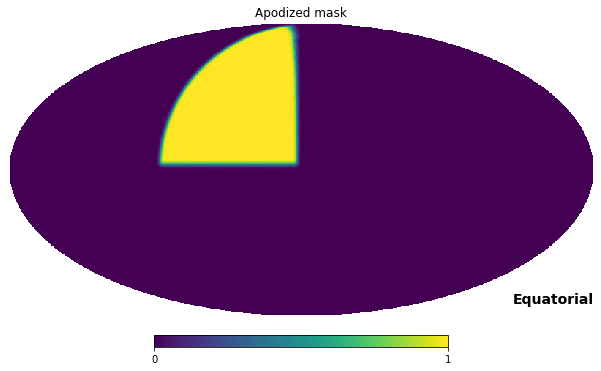

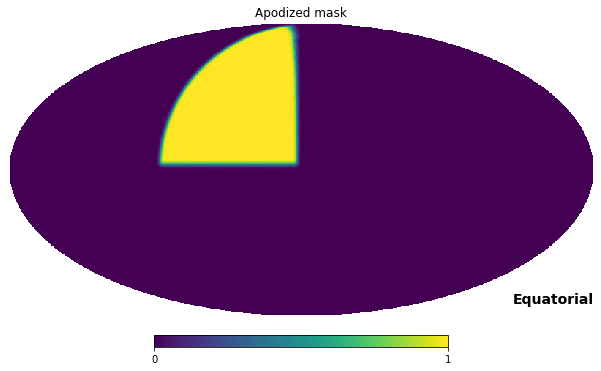

In [4]:
bias_optimos = []
Errores_bias_optimos = []
for i in range(10):
    T = hp.read_map("/scratch/davfer/Cosmohub/Mollview_T_HI_0_{:.0f}_0_{:.0f}_disp_catalogo_completo_jupyter.fits".format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]), field=0, verbose=False)
    T_mean = np.mean(T[pix_ocupados])
    Delta_T = T - T_mean
    
    # Import the NaMaster python wrapper
    

    #  Simple example showcasing the use of NaMaster to compute the pseudo-Cl
    #  estimator of the angular cross-power spectrum of a spin-0 field and a
    #  spin-2 field

    # HEALPix resolution parameter used here
    nside = 256
    npix = hp.nside2npix(nside)

    # Read mask and apodize it on a scale of ~1deg
    mask = nmt.mask_apodization(mascara, 1., apotype="Smooth")
    hp.mollview(mask, coord=['C'], title='Apodized mask')
    plt.show()

    # Read healpix maps and initialize a spin-0 and spin-2 field
    f_0 = nmt.NmtField(mask, [Delta_T])
    #f_2 = nmt.NmtField(mask, hp.read_map("/afs/ciemat.es/user/d/davfer/public/Mollview_T_HI_0_5_0_6_catalogo_completo_jupyter.fits", field=[1, 2], verbose=False))

    # Initialize binning scheme with 20 ells per bandpower
    b = nmt.NmtBin.from_nside_linear(nside, 20)
    ell_arr = b.get_effective_ells()
    i_primeros_puntos = np.where(ell_arr < 400)[0]
    delta_ell_arr = ell_arr[1:]-ell_arr[:-1]
    delta_ell_arr = np.append(delta_ell_arr,delta_ell_arr[-1])
    # Compute MASTER estimator
    # spin-0 x spin-0
    cl_00 = nmt.compute_full_master(f_0, f_0, b)
    # spin-0 x spin-2
    #cl_02 = nmt.compute_full_master(f_0, f_2, b)
    # spin-2 x spin-2
    #cl_22 = nmt.compute_full_master(f_2, f_2, b)

    #Teorico (pyccl)
    z = np.loadtxt('/scratch/davfer/Cosmohub/z_array_0_{:.0f}_0_{:.0f}_disp.txt'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    N_z = np.loadtxt('/scratch/davfer/Cosmohub/z_hist_0_{:.0f}_0_{:.0f}_disp.txt'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    dndz = (z,N_z)
    ell = np.linspace(1,800,100)

    bias_valores = np.arange(0.5,2.01,0.01)
    Chi_2 = []

    for j in range(len(bias_valores)):
        bias = (z,np.full(len(z),bias_valores[j]))
        has_rsd = False
        cltracer1 = pyccl.tracers.NumberCountsTracer(cosmo, has_rsd, dndz, bias, mag_bias=None)
        cltracer2 = cltracer1
        limber_integration_method = 'qag_quad'
        l_limber = -1.0
        p_of_k_a = None
        cl = pyccl.cls.angular_cl(cosmo, cltracer1, cltracer2, ell_arr, p_of_k_a, l_limber)*T_mean**2
        chi_2 = sum((cl_00[0]-bias_valores[j]*cl)**2*(2*ell_arr+1)*delta_ell_arr*(1/8)/(2*cl_00[0]**2))
        Chi_2.append(chi_2)
    Chi_2 = np.array(Chi_2)
    j_optimo = np.where(Chi_2 == min(Chi_2))[0]
    bias_optimo = bias_valores[j_optimo]
    bias_optimos.append(bias_optimo)
    bias = (z,np.full(len(z),bias_optimo))
    has_rsd = False
    cltracer1 = pyccl.tracers.NumberCountsTracer(cosmo, has_rsd, dndz, bias, mag_bias=None)
    cltracer2 = cltracer1
    limber_integration_method = 'qag_quad'
    l_limber = -1.0
    p_of_k_a = None
    cl = pyccl.cls.angular_cl(cosmo, cltracer1, cltracer2, ell, p_of_k_a, l_limber)*T_mean**2
    
    #Ahora mismo está restringida a l < lmax = 400 porque la Chi_2_fun se definió así
    Likelihood_no_norm = np.exp(-Chi_2/2)
    Norm = 1/(np.sum(Likelihood_no_norm*0.01))
    Likelihood = Norm*Likelihood_no_norm
    Mean = np.sum(Likelihood*bias_valores*0.01)
    Varianza_bias = np.sum(Likelihood*(bias_valores-Mean)**2*0.01)
    Error_bias = np.sqrt(Varianza_bias)
    Errores_bias_optimos.append(Error_bias)
    

In [5]:
### import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
import camb
from camb import model, initialpower
from colossus.cosmology import cosmology  
from colossus.halo import mass_so
from colossus.lss import mass_function
from colossus.lss import bias


params = cosmology.cosmologies['planck15']
params['Om0'] = 0.281
params['Ob0'] = 0.0462
params['Ode0'] = 0.719
params['H0'] = 71
cosmo = cosmology.setCosmology('planck15',params)


Omega_m = 0.25
Omega_b = 0.044
Omega_lambda = 0.75
h = 0.70
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s

pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=0.02156, omch2=0.1225, mnu=0, omk=0, tau=0.06)

def M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c):
    v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    f_HI=(Omega_b/Omega_m)*(0.75) # (1-Y)*Omega_b/Omega_m
    return alpha*f_HI*M*((M*h/1e11)**beta)*np.exp(-(v_c0/v_c)**3)*np.exp(-(v_c/v_c1)**3)
np.vectorize(M_HI)

# Se va a intentar despejar n de ahí. Se tiene que n=(dn/dlnM) (unidades de (Mpc/h)**(-3))
def n(Masa, z):
    n = mass_function.massFunction(Masa, z, mdef = 'fof', model = 'sheth99', q_out = 'dndlnM')
    return n


def bias_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h):
    Masa = np.logspace(1,15,500)
    potencia = np.log10(Masa[1]/Masa[0])
    dMasa = Masa*(10**potencia-1)
    Delta_c = mass_so.deltaVir(z)
    integral_1 = (1/Masa)*n(Masa, z)*M_HI(Masa,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*bias.haloBias(Masa, model = 'jing98', z = z, mdef = 'vir')*dMasa
    integral_1 = sum(integral_1)
                                 
    integral_2 = (1/Masa)*n(Masa, z)*M_HI(Masa,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*dMasa
    integral_2 = sum(integral_2)
    bias_HI = integral_1/integral_2
    return bias_HI

bias_HI = np.vectorize(bias_HI)

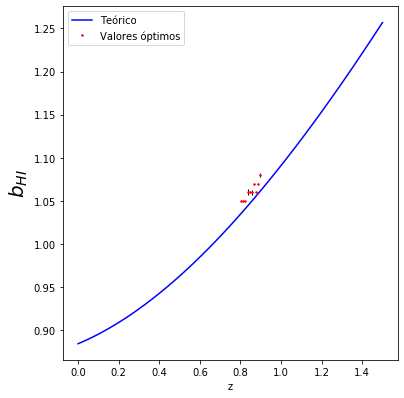

In [6]:
z=np.linspace(0,1.5,100,endpoint=True)
plt.figure(figsize=(6,6.5))
plt.plot(z,bias_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h),'b-',label='Teórico')
plt.plot(z_bin_centers,bias_optimos,'r.', markersize=3, label='Valores óptimos')
plt.errorbar(z_bin_centers,bias_optimos, yerr=Errores_bias_optimos, fmt='None', ecolor='k',elinewidth=1)
plt.xlabel('z')
plt.ylabel(r'$b_{HI}$',fontsize=20)
plt.legend(loc='best')
ax = plt.gca()
#plt.ylim([0.7,2.2])
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.savefig('../Plots/bias_evolucion_comparado_disp.png',bbox_inches='tight',dpi=900)
plt.show()